In [1]:
# === CONFIG ===
IMG_GLOBS = ["chess/*.jpg", "chess/*.png"]  # 사진 폴더/패턴
PATTERN_COLS, PATTERN_ROWS = 9, 6            # "내부 코너" 개수(가로, 세로)
SQUARE_SIZE = 1.0                             # 한 칸 변 길이(임의 단위, 품질평가엔 영향 없음)

OUT_DIR = "calib_qc"                          # 결과(오버레이/리포트) 저장 폴더
SAVE_OVERLAYS = True                          # 코너 오버레이 이미지 저장할지 여부
DRAW_MAX = 40                                 # 오버레이 저장 상한(과하면 용량 커져서)

# 품질 기준(경험값, 필요시 조정)
BLUR_VAR_MIN = 80.0         # 라플라시안 분산(초점 선명도) 최소
SAT_WHITE_MAX = 0.01        # 흰색 포화 비율 상한(=1% 이하 권장)
EDGE_KISS_THRESH = 0.05     # 프레임 가장자리 5% 이내면 "코너 키스"로 간주


In [2]:
import os, glob, math, pathlib, io
import numpy as np
import cv2
from collections import defaultdict
from math import atan2, degrees

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

def load_paths(globs):
    paths = []
    for g in globs:
        paths.extend(glob.glob(g))
    return sorted(paths)

def variance_of_laplacian(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def white_saturation_ratio(gray):
    # 8bit 기준: 아주 밝은 영역 비율(하이라이트 클리핑 근사)
    return float(np.mean(gray >= 250))

def detect_corners_both(img, pattern_size):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # SB 먼저(가능하면 가장 튼튼)
    if hasattr(cv2, "findChessboardCornersSB"):
        ret, corners = cv2.findChessboardCornersSB(gray, pattern_size)
        if ret and corners is not None:
            if corners.ndim == 2 and corners.shape[1] == 2:
                corners = corners.reshape(-1,1,2)
            return True, corners.astype(np.float32), gray
    # fallback
    flags = (cv2.CALIB_CB_ADAPTIVE_THRESH |
             cv2.CALIB_CB_NORMALIZE_IMAGE |
             cv2.CALIB_CB_FAST_CHECK)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, flags)
    if not ret:
        return False, None, gray
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1e-4)
    corners = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), term)
    return True, corners.astype(np.float32), gray

def roll_angle_deg(corners, cols, rows):
    # 첫 행의 좌우 코너로 롤(평면 내 회전) 근사
    i0 = 0
    i1 = cols - 1
    p0 = corners[i0,0]; p1 = corners[i1,0]
    dx, dy = p1[0]-p0[0], p1[1]-p0[1]
    return degrees(atan2(dy, dx))

def center_norm(corners, w, h):
    c = np.mean(corners[:,0,:], axis=0)
    return float(c[0]/w), float(c[1]/h)

def edge_kiss_flags(corners, w, h, thresh=0.05):
    # 체스보드의 바깥쪽 컨벡스헐을 쓰기엔 복잡 → 코너 집합의 (minx,miny,maxx,maxy)로 근사
    xs = corners[:,0,0]; ys = corners[:,0,1]
    minx, maxx = float(xs.min()), float(xs.max())
    miny, maxy = float(ys.min()), float(ys.max())
    # 프레임 가장자리까지의 정규화 거리
    left  = minx / w
    right = (w - maxx) / w
    top   = miny / h
    bot   = (h - maxy) / h
    return dict(
        left = left  <= thresh,
        right= right <= thresh,
        top  = top   <= thresh,
        bot  = bot   <= thresh
    )

def perspective_skew_metrics(corners, cols, rows):
    # 행/열 평균 간격 비로 피치/요 왜곡을 거칠게 점수화(1.0이면 대칭적)
    # 가로 간격
    row_dists = []
    for r in range(rows):
        row_pts = corners[r*cols:(r+1)*cols,0,:]
        d = np.mean(np.linalg.norm(np.diff(row_pts, axis=0), axis=1))
        row_dists.append(d)
    # 세로 간격
    col_dists = []
    for c in range(cols):
        col_pts = corners[c::cols,0,:]
        d = np.mean(np.linalg.norm(np.diff(col_pts, axis=0), axis=1))
        col_dists.append(d)
    # 위/아래, 좌/우 평균 비율(멀어짐/가까워짐 판단용)
    up, dn = np.mean(row_dists[:2]), np.mean(row_dists[-2:])
    lf, rt = np.mean(col_dists[:2]), np.mean(col_dists[-2:])
    ratio_row = min(up,dn) / max(up,dn) if max(up,dn)>0 else 1.0
    ratio_col = min(lf,rt) / max(lf,rt) if max(lf,rt)>0 else 1.0
    return ratio_row, ratio_col  # 1.0에 가까울수록 정면


In [3]:
paths = load_paths(IMG_GLOBS)
if not paths:
    raise SystemExit("이미지 경로 패턴에 매칭되는 파일이 없습니다. IMG_GLOBS를 확인하세요.")

cols, rows = PATTERN_COLS, PATTERN_ROWS
pattern_size = (cols, rows)

used = []
failed = []
qc = []  # 품질 메트릭 저장

overlay_count = 0

for p in paths:
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    if img is None:
        failed.append((p, "read_fail"))
        continue
    h, w = img.shape[:2]

    ok, corners, gray = detect_corners_both(img, pattern_size)
    blur = variance_of_laplacian(gray)
    sat = white_saturation_ratio(gray)

    if not ok:
        failed.append((p, "corners_not_found", dict(blur=blur, sat=sat)))
        continue

    # 품질 메트릭
    roll = roll_angle_deg(corners, cols, rows)              # 회전
    cx, cy = center_norm(corners, w, h)                     # 보드 중심 위치
    kiss = edge_kiss_flags(corners, w, h, EDGE_KISS_THRESH) # 에지 접촉 플래그
    r_row, r_col = perspective_skew_metrics(corners, cols, rows)

    qc.append(dict(
        path=p, w=w, h=h,
        blur=blur, sat=sat,
        roll=roll, cx=cx, cy=cy,
        kiss_left=kiss["left"], kiss_right=kiss["right"], kiss_top=kiss["top"], kiss_bot=kiss["bot"],
        ratio_row=r_row, ratio_col=r_col
    ))
    used.append(p)

    if SAVE_OVERLAYS and overlay_count < DRAW_MAX:
        dbg = img.copy()
        cv2.drawChessboardCorners(dbg, pattern_size, corners, True)
        outp = os.path.join(OUT_DIR, f"overlay_{overlay_count:03d}_{os.path.basename(p)}")
        cv2.imwrite(outp, dbg)
        overlay_count += 1

# ---- 요약 리포트 ----
import statistics

N = len(paths)
Nu = len(used)
Nf = len(failed)

blurs = [d["blur"] for d in qc]
sats  = [d["sat"] for d in qc]
rolls = [d["roll"] for d in qc]
cxs   = [d["cx"] for d in qc]
cys   = [d["cy"] for d in qc]

edge_hits = dict(
    left = sum(1 for d in qc if d["kiss_left"]),
    right= sum(1 for d in qc if d["kiss_right"]),
    top  = sum(1 for d in qc if d["kiss_top"]),
    bot  = sum(1 for d in qc if d["kiss_bot"]),
)

def pct(x, total): 
    return f"{(100.0*x/total):.1f}%" if total>0 else "0.0%"

lines = []
lines.append(f"[DATA] total={N}, usable={Nu} ({pct(Nu,N)}), failed={Nf} ({pct(Nf,N)})")
if Nu>0:
    lines.append(f"[FOCUS] Laplacian variance: median={statistics.median(blurs):.1f}, min={min(blurs):.1f}")
    lines.append(f"[EXPOSE] white saturation ratio: median={statistics.median(sats):.4f}, max={max(sats):.4f}")
    lines.append(f"[ROLL] deg: min={min(rolls):.1f}, max={max(rolls):.1f}")
    lines.append(f"[CENTER] cx mean={statistics.mean(cxs):.3f}, cy mean={statistics.mean(cys):.3f}")
    lines.append(f"[EDGE KISS] L={edge_hits['left']}({pct(edge_hits['left'],Nu)}), "
                 f"R={edge_hits['right']}({pct(edge_hits['right'],Nu)}), "
                 f"T={edge_hits['top']}({pct(edge_hits['top'],Nu)}), "
                 f"B={edge_hits['bot']}({pct(edge_hits['bot'],Nu)})")
    # 강한 기울기 포즈 지표(비율이 1.0에서 멀수록 기울기 큼)
    rrow = [d["ratio_row"] for d in qc]
    rcol = [d["ratio_col"] for d in qc]
    lines.append(f"[TILT proxy] row_ratio min={min(rrow):.3f}, col_ratio min={min(rcol):.3f}")

report_txt = "\n".join(lines)
print(report_txt)

# 실패 목록 요약 저장
with open(os.path.join(OUT_DIR, "qc_report.txt"), "w", encoding="utf-8") as f:
    f.write(report_txt + "\n\n")
    if failed:
        f.write("[FAILED LIST]\n")
        for item in failed:
            f.write(str(item) + "\n")

print(f"[WRITE] {os.path.join(OUT_DIR, 'qc_report.txt')}")


[DATA] total=140, usable=131 (93.6%), failed=9 (6.4%)
[FOCUS] Laplacian variance: median=180.7, min=71.6
[EXPOSE] white saturation ratio: median=0.0240, max=0.1466
[ROLL] deg: min=-179.9, max=179.7
[CENTER] cx mean=0.444, cy mean=0.588
[EDGE KISS] L=10(7.6%), R=7(5.3%), T=7(5.3%), B=1(0.8%)
[TILT proxy] row_ratio min=0.787, col_ratio min=0.715
[WRITE] calib_qc\qc_report.txt


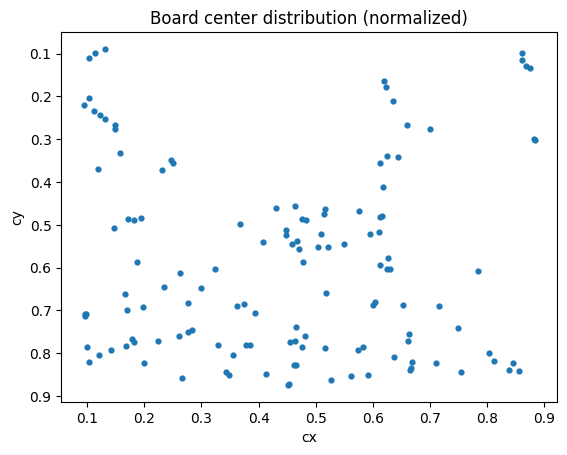

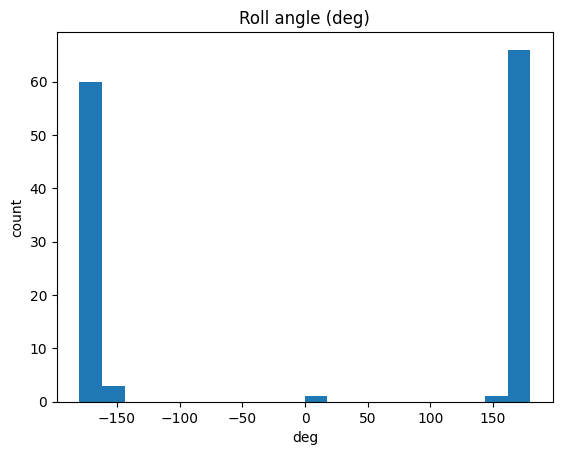

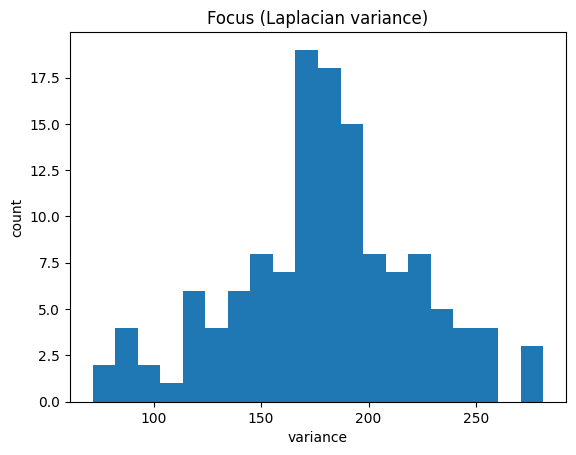

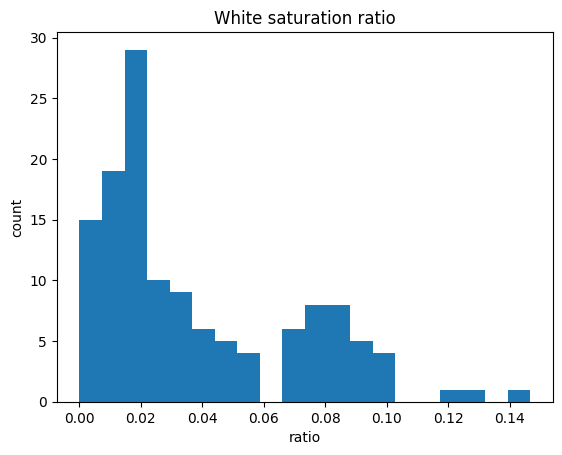

In [4]:
import matplotlib.pyplot as plt

if qc:
    # 보드 중심 분포
    xs = [d["cx"] for d in qc]
    ys = [d["cy"] for d in qc]
    plt.figure()
    plt.scatter(xs, ys, s=12)
    plt.title("Board center distribution (normalized)")
    plt.xlabel("cx"); plt.ylabel("cy")
    plt.gca().invert_yaxis()  # 이미지 좌표계 감안
    plt.show()

    # 롤 각도 히스토그램
    plt.figure()
    plt.hist([d["roll"] for d in qc], bins=20)
    plt.title("Roll angle (deg)")
    plt.xlabel("deg"); plt.ylabel("count")
    plt.show()

    # 초점 선명도
    plt.figure()
    plt.hist([d["blur"] for d in qc], bins=20)
    plt.title("Focus (Laplacian variance)")
    plt.xlabel("variance"); plt.ylabel("count")
    plt.show()

    # 흰색 포화 비율
    plt.figure()
    plt.hist([d["sat"] for d in qc], bins=20)
    plt.title("White saturation ratio")
    plt.xlabel("ratio"); plt.ylabel("count")
    plt.show()
else:
    print("usable 이미지가 없어 시각화를 건너뜁니다.")


In [7]:
BLUR_MIN, SAT_MAX, MAX_USE = 120.0, 0.06, 140
good = [d["path"] for d in qc if d["blur"]>=BLUR_MIN and d["sat"]<=SAT_MAX]
if len(good) > MAX_USE:
    step = len(good)/MAX_USE
    good = [good[int(i*step)] for i in range(MAX_USE)]
print("using", len(good), "images")

# ← 여기서 이전에 준 보정 셀의 paths 대신 good을 넣어 실행
# 결과로 OUT_DIR/calib.npz 저장 (K, D, newK, map1, map2 포함)

using 87 images


In [8]:
# === [Calib-1] 이미지 목록과 robust 코너 추출 (BGR 입력) ===
import os, cv2, numpy as np
from glob import glob

# 네 노트북에서 쓰던 값 재사용 (없으면 기본값)
try:
    PATTERN_COLS, PATTERN_ROWS
except NameError:
    PATTERN_COLS, PATTERN_ROWS = 9, 6   # 내부 코너 수(칸-1)

try:
    IMG_GLOBS
except NameError:
    IMG_GLOBS = ["chess/*.jpg", "chess/*.png"]

# 후보 이미지: QC에서 만든 good 리스트가 있으면 우선 사용
if "good" in globals() and isinstance(good, (list, tuple)) and len(good) > 0:
    paths_for_calib = list(good)
    print(f"[INFO] using 'good' list: {len(paths_for_calib)} images")
else:
    paths_for_calib = sorted([p for g in IMG_GLOBS for p in glob(g)])
    print(f"[INFO] 'good' not found → using all: {len(paths_for_calib)} images")

# ⚠️ detect_corners_both는 BGR 이미지를 기대하므로 BGR을 그대로 전달
def robust_find_bgr(bgr, cols, rows):
    ret = detect_corners_both(bgr, (cols, rows))  # <- BGR 입력
    # 반환 형태가 (ok, corners) 또는 (ok, corners, vis) 등일 수 있으니 호환
    if isinstance(ret, tuple) and len(ret) >= 2:
        ok, corners = bool(ret[0]), ret[1]
        if corners is None:
            return False, None
        c = np.asarray(corners, dtype=np.float32)
        if c.ndim == 2 and c.shape[1] == 2:  # (N,2) → (N,1,2)
            c = c.reshape(-1, 1, 2)
        return ok, c
    return False, None

# 오브젝트 포인트(격자 스케일은 1로 두면 됨)
objp = np.zeros((PATTERN_ROWS*PATTERN_COLS, 3), np.float32)
grid = np.mgrid[0:PATTERN_COLS, 0:PATTERN_ROWS].T.reshape(-1, 2).astype(np.float32)
objp[:, :2] = grid

objpoints, imgpoints, kept = [], [], []
for p in paths_for_calib:
    im = cv2.imread(p, cv2.IMREAD_COLOR)
    if im is None:
        continue
    ok, corners = robust_find_bgr(im, PATTERN_COLS, PATTERN_ROWS)  # <- 그레이로 바꾸지 말고 BGR 그대로!
    if not ok:
        # print("[miss]", p)
        continue
    objpoints.append(objp.copy())
    imgpoints.append(corners.astype(np.float32))
    kept.append(p)

print(f"[KEEP] {len(kept)} / {len(paths_for_calib)} images kept for calibration")
if len(kept) < 8:
    raise RuntimeError("이미지가 너무 적어요(최소 8장 권장). 패턴 칸수/코너 검출/데이터를 확인하세요.")


[INFO] using 'good' list: 87 images
[KEEP] 87 / 87 images kept for calibration


In [9]:
# === [Calib-2] pinhole & fisheye 둘 다 계산 → 더 낮은 RMS 선택, npz 저장 ===
import pathlib

OUT_CALIB_DIR = "calib_out"
pathlib.Path(OUT_CALIB_DIR).mkdir(parents=True, exist_ok=True)

# 이미지 크기
H, W = cv2.imread(kept[0]).shape[:2]
size = (W, H)

def calib_pinhole():
    rms, K, D, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)
    # alpha=0 (가장 많이 크롭)로 기본 리맵 생성. 필요시 아래 셀에서 다시 만들 수 있음.
    newK, _ = cv2.getOptimalNewCameraMatrix(K, D, size, alpha=0.0, newImgSize=size)
    m1, m2 = cv2.initUndistortRectifyMap(K, D, None, newK, size, cv2.CV_16SC2)
    return {"model":"pinhole","rms":float(rms),"K":K,"D":D,"newK":newK,"map1":m1,"map2":m2}

def calib_fisheye():
    O = [o.reshape(1,-1,3).astype(np.float64) for o in objpoints]
    I = [i.reshape(1,-1,2).astype(np.float64) for i in imgpoints]
    K = np.eye(3, dtype=np.float64)
    D = np.zeros((4,1), np.float64)
    flags = (cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC |
             cv2.fisheye.CALIB_CHECK_COND |
             cv2.fisheye.CALIB_FIX_SKEW)
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)
    rms, K, D, rvecs, tvecs = cv2.fisheye.calibrate(O, I, size, K, D, None, None, flags, term)
    R = np.eye(3)
    newK = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, size, R, balance=0.0)  # balance는 아래 셀에서 조절 가능
    m1, m2 = cv2.fisheye.initUndistortRectifyMap(K, D, R, newK, size, cv2.CV_16SC2)
    return {"model":"fisheye","rms":float(rms),"K":K,"D":D,"newK":newK,"map1":m1,"map2":m2}

P = calib_pinhole()
F = calib_fisheye()

best = P if P["rms"] <= F["rms"] else F
print("[RMS] pinhole=%.4f, fisheye=%.4f → choose: %s" % (P["rms"], F["rms"], best["model"]))

np.savez_compressed(
    os.path.join(OUT_CALIB_DIR, "calib.npz"),
    model=best["model"], rms=np.float32(best["rms"]),
    K=best["K"], D=best["D"], newK=best["newK"],
    map1=best["map1"], map2=best["map2"],
    img_size=np.array(size, np.int32),
    pattern=np.array([PATTERN_COLS, PATTERN_ROWS], np.int32),
    used_images=np.array(kept)
)
print("[SAVED]", pathlib.Path(OUT_CALIB_DIR, "calib.npz").resolve())


[RMS] pinhole=2.6272, fisheye=0.2635 → choose: fisheye
[SAVED] C:\Users\gmlwn\OneDrive\바탕 화면\ICon1학년\광통신\PTCamera_waveshare\test_set\chess_try_1\calib_out\calib.npz


In [10]:
# === [Calib-3] Quick sanity check: 5장 remap 저장 ===
cal = np.load(os.path.join(OUT_CALIB_DIR, "calib.npz"), allow_pickle=True)
m1, m2 = cal["map1"], cal["map2"]
used = list(map(str, cal["used_images"]))

for p in used[:5]:
    im  = cv2.imread(p)
    und = cv2.remap(im, m1, m2, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    out = pathlib.Path(OUT_CALIB_DIR, pathlib.Path(p).stem + "_ud.jpg")
    cv2.imwrite(str(out), und)
    print("wrote", out)
print("done.")


wrote calib_out\snap_20250908_120432_ud.jpg
wrote calib_out\snap_20250908_120437_ud.jpg
wrote calib_out\snap_20250908_120443_ud.jpg
wrote calib_out\snap_20250908_120502_ud.jpg
wrote calib_out\snap_20250908_120508_ud.jpg
done.
